### **Required Libraries**

In [ ]:
!pip install transformers datasets tensorflow bs4 python-dotenv
!pip install sentencepiece

In [ ]:
import os
import requests
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from bs4 import BeautifulSoup
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix
from transformers import AutoTokenizer, TFAutoModelForSequenceClassification, pipeline
from huggingface_hub import login
from dotenv import load_dotenv
from warnings import filterwarnings
filterwarnings('ignore')

### **Data Collection**

In [ ]:
# Dataset download from Kaggle
!kaggle datasets download -d gopiashokan/financial-document-classification-dataset

Dataset URL: https://www.kaggle.com/datasets/gopiashokan/financial-document-classification-dataset
License(s): MIT
  0% 0.00/2.75M [00:00<?, ?B/s]
100% 2.75M/2.75M [00:00<00:00, 95.7MB/s]


In [ ]:
# Extract the Data from Zip File
!unzip financial-document-classification-dataset.zip

### **Data Preprocessing**

In [ ]:
def text_extract_from_html(html_file):

    # Open and Read the HTML File
    with open(file=html_file, mode='r', encoding='utf-8') as file:
        html_content = file.read()

    # Parse the HTML Content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract the Text
    text = soup.get_text()

    # Split the Text and Remove Unwanted Space
    result = [i.strip() for i in text.split()]

    return result

In [ ]:
# Extract Text from All HTML Documents

dataset_path = '/content/data'

file_name = []
extracted_text = []
target = []

for folder_name in os.listdir(dataset_path):

    # Make a Target_Folder Path
    path = os.path.join(dataset_path, folder_name)

    for html_file in os.listdir(path):

        # Verify the File as HTML_File or not
        if html_file.endswith('.html'):

            # Make a HTML File Path
            html_file_path = os.path.join(dataset_path, folder_name, html_file)

            # Extract the Text from HTML Document
            result = text_extract_from_html(html_file_path)

            # Append the Data into List
            file_name.append(html_file)
            extracted_text.append(result)
            target.append(folder_name)

In [ ]:
# Number of Total Documents
len(file_name), len(extracted_text), len(target)

(2525, 2525, 2525)

In [ ]:
df = pd.DataFrame({'file_name':file_name, 'text':extracted_text, 'label':target})
df

,file_name,text,label
0,18543527_11.html,"[S., No., Name, and, Designation, Address, 1.,...",Others
1,18540991_8.html,"[Particulars, As, at, March, 31,2018, Capital,...",Others
2,18849910_9.html,"[Standalone, Consol, dated, Q4, FY18, Q4, FY17...",Others
3,18582946_2.html,"[Standalone, Results, Sr, No., Quarter, Ended,...",Others
4,18586111_16.html,"[%, Q1, FY, 18, Q4, FY, 17, Q3, FY, 17, Q2, FY...",Others
...,...,...,...
2520,18944708_1.html,"[_, _, _, Hi, Hn, 1, 1, ■_, ■, ■, 1, LIMITED, ...",Income Statement
2521,18950001_1.html,"[“, Standalone, SI., Particulars, Quarter, End...",Income Statement
2522,18460658_74.html,"[Particulars, Quarter, Ended, Mar-18, Dec-17, ...",Income Statement
2523,18849925_5.html,"[Standalone, Consolidated, Quarter, ended, Yea...",Income Statement


In [2]:
# # Create a dictionary that Map each unique label to a unique index
label_mapping = {label: idx for idx, label in enumerate(df['label'].unique())}
print(label_mapping)

{'Others': 0, 'Balance Sheets': 1, 'Notes': 2, 'Cash Flow': 3, 'Income Statement': 4}


In [ ]:
# Map values in 'label' column based on the 'label_mapping' dictionary
df['label'] = df['label'].map(label_mapping)
df.tail(3)

,file_name,text,label
2522,18460658_74.html,"[Particulars, Quarter, Ended, Mar-18, Dec-17, ...",4
2523,18849925_5.html,"[Standalone, Consolidated, Quarter, ended, Yea...",4
2524,18671329_3.html,"[SL., Standalone, Consolidated, No., Quarter, ...",4


In [ ]:
# Split into train/test
train_texts, test_texts, train_labels, test_labels = train_test_split(
    df["text"].tolist(), df["label"].tolist(), test_size=0.2, random_state=42
)

In [ ]:
# Load FinBERT tokenizer
tokenizer = AutoTokenizer.from_pretrained("yiyanghkust/finbert-pretrain")
tokenizer

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/359 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/226k [00:00<?, ?B/s]

BertTokenizerFast(name_or_path='yiyanghkust/finbert-pretrain', vocab_size=30873, model_max_length=1000000000000000019884624838656, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True, added_tokens_decoder={
	0: AddedToken("[PAD]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	2: AddedToken("[UNK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	3: AddedToken("[CLS]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	4: AddedToken("[SEP]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
	5: AddedToken("[MASK]", rstrip=False, lstrip=False, single_word=False, normalized=False, special=True),
}
)

In [ ]:
# Tokenize function
def tokenize_data(texts):
    texts = [" ".join(text) for text in texts]
    return tokenizer(texts, padding=True, truncation=True, max_length=512, return_tensors="tf")

In [ ]:
# Tokenize train/test data
train_encodings = tokenize_data(train_texts)
train_encodings

{'input_ids': <tf.Tensor: shape=(2020, 512), dtype=int32, numpy=
array([[   3,  643,   63, ...,    0,    0,    0],
       [   3,  643,   63, ...,    0,    0,    0],
       [   3,  643,   63, ...,    0,    0,    0],
       ...,
       [   3, 2514, 6744, ...,    0,    0,    0],
       [   3, 6622,  206, ...,  727,   48,    4],
       [   3,  643,   63, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(2020, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(2020, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 1, 1, 1],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
test_encodings = tokenize_data(test_texts)
test_encodings

{'input_ids': <tf.Tensor: shape=(505, 512), dtype=int32, numpy=
array([[   3,  912,    8, ...,    0,    0,    0],
       [   3,   11,   48, ...,    0,    0,    0],
       [   3,    6, 4351, ...,    0,    0,    0],
       ...,
       [   3,  643,   63, ...,    0,    0,    0],
       [   3,  643,   63, ...,    0,    0,    0],
       [   3,   47,   66, ...,    0,    0,    0]], dtype=int32)>, 'token_type_ids': <tf.Tensor: shape=(505, 512), dtype=int32, numpy=
array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]], dtype=int32)>, 'attention_mask': <tf.Tensor: shape=(505, 512), dtype=int32, numpy=
array([[1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       ...,
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0],
       [1, 1, 1, ..., 0, 0, 0]], dtype=int32)>}

In [ ]:
# Convert to TensorFlow dataset
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings), tf.convert_to_tensor(train_labels)
)).batch(8)

train_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings), tf.convert_to_tensor(test_labels)
)).batch(8)

test_dataset

<_BatchDataset element_spec=({'input_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'token_type_ids': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None), 'attention_mask': TensorSpec(shape=(None, 512), dtype=tf.int32, name=None)}, TensorSpec(shape=(None,), dtype=tf.int32, name=None))>

### **Model Training & Evaluation**

In [ ]:
# Load FinBERT for classification
model = TFAutoModelForSequenceClassification.from_pretrained(
          "yiyanghkust/finbert-pretrain",
          num_labels=len(label_mapping),
          from_pt=True
)

model

pytorch_model.bin:   0%|          | 0.00/442M [00:00<?, ?B/s]

All PyTorch model weights were used when initializing TFBertForSequenceClassification.

Some weights or buffers of the TF 2.0 model TFBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['classifier.weight', 'classifier.bias']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
# Compile model
optimizer = tf.keras.optimizers.Adam(learning_rate=5e-5)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

model.compile(optimizer=optimizer, loss=loss, metrics=["accuracy"])
model

In [ ]:
# Train the model
history = model.fit(train_dataset, validation_data=test_dataset, epochs=3)
history

Epoch 1/3
253/253 [==============================] - 300s 1s/step - loss: 0.3373 - accuracy: 0.8916 - val_loss: 0.2106 - val_accuracy: 0.9386
Epoch 2/3
253/253 [==============================] - 257s 1s/step - loss: 0.1155 - accuracy: 0.9668 - val_loss: 0.1491 - val_accuracy: 0.9584
Epoch 3/3
253/253 [==============================] - 260s 1s/step - loss: 0.0537 - accuracy: 0.9851 - val_loss: 0.1795 - val_accuracy: 0.9584


In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(test_dataset)
print(f"Test Accuracy: {accuracy:.4f}")

64/64 [==============================] - 20s 311ms/step - loss: 0.1795 - accuracy: 0.9584
Test Accuracy: 0.9584


In [ ]:
# Predict on the test dataset
predictions = model.predict(test_dataset)
predictions

64/64 [==============================] - 23s 312ms/step


TFSequenceClassifierOutput(loss=None, logits=array([[ 2.48574   , -1.4604118 ,  3.1016219 , -3.212811  , -2.2835655 ],
       [ 6.3067856 , -1.135364  , -0.64896816, -2.3524797 , -2.172157  ],
       [ 6.801204  , -1.3755339 , -1.41392   , -1.5390751 , -2.0069335 ],
       ...,
       [ 6.8065906 , -1.0799997 , -1.7070782 , -1.6308147 , -1.9608169 ],
       [ 6.8551707 , -0.9533801 , -1.9269737 , -1.4687493 , -2.1043599 ],
       [ 5.742726  , -1.4233074 ,  0.17157513, -2.444131  , -2.138266  ]],
      dtype=float32), hidden_states=None, attentions=None)

In [ ]:
# Get the predicted class by taking the argmax of logits
predicted_classes = np.argmax(predictions.logits, axis=1)
print(predicted_classes)

[2 0 0 0 1 0 2 0 2 0 4 2 0 1 2 0 4 1 4 0 2 2 0 1 0 0 2 2 2 0 2 4 4 0 0 0 0
 0 0 0 2 0 1 4 2 4 2 2 0 2 1 2 0 2 1 0 2 0 0 2 0 1 2 0 0 0 0 0 0 1 2 2 0 1
 0 0 2 0 2 2 2 1 1 4 0 2 0 1 0 4 4 0 1 4 2 2 0 2 0 2 0 2 0 0 0 0 4 4 2 0 0
 0 2 2 0 3 0 0 0 4 0 0 1 2 1 0 2 2 2 0 1 2 1 0 0 4 2 2 0 3 2 0 2 1 0 2 2 0
 2 4 4 2 2 0 2 0 0 2 0 2 4 0 0 4 2 0 0 0 4 1 2 4 2 0 2 2 2 4 2 2 2 1 0 0 2
 2 0 2 2 0 2 2 0 0 0 0 0 0 0 4 0 1 0 0 0 0 4 0 0 0 2 0 2 2 0 4 0 0 0 0 4 0
 0 0 0 0 1 2 0 2 2 2 4 0 0 2 1 0 0 0 2 2 1 0 0 0 0 0 0 1 1 2 0 0 1 0 4 0 0
 0 2 4 0 2 4 2 1 2 1 2 0 0 0 2 4 0 0 3 2 0 0 0 2 0 2 0 2 0 1 0 0 0 1 1 2 4
 0 2 2 2 0 0 0 0 4 2 0 2 1 0 2 2 2 0 0 1 1 0 0 0 0 0 0 0 3 2 0 2 0 2 2 2 2
 0 0 0 1 0 2 0 2 2 0 0 0 1 0 0 1 0 0 2 2 2 0 1 0 0 2 1 1 0 2 4 0 2 0 2 4 0
 0 1 0 0 0 2 2 0 0 4 0 0 1 0 2 0 1 2 0 0 1 2 1 2 2 4 4 0 1 1 2 0 0 0 0 0 0
 0 0 2 0 0 3 0 0 4 4 4 2 0 0 2 4 0 0 1 0 0 1 0 4 4 2 0 0 0 2 2 1 2 2 2 4 0
 0 0 2 2 0 0 2 2 0 0 0 4 4 4 0 0 0 4 0 2 2 2 0 0 2 4 0 0 2 1 0 2 0 2 2 2 2
 3 0 0 0 2 0 0 2 0 0 2 0 

In [ ]:
# Get the true labels
true_labels = []
for batch in test_dataset:
    true_labels.extend(batch[1].numpy())

true_labels = np.array(true_labels)
true_labels

array([2, 0, 0, 0, 1, 0, 2, 0, 2, 0, 4, 2, 0, 1, 2, 0, 4, 1, 4, 0, 2, 2,
       0, 1, 0, 0, 2, 2, 2, 0, 2, 4, 4, 0, 0, 0, 0, 2, 0, 0, 2, 0, 1, 4,
       2, 4, 2, 2, 0, 2, 1, 2, 0, 2, 1, 0, 2, 0, 0, 2, 4, 1, 2, 0, 0, 0,
       0, 0, 0, 1, 2, 2, 0, 1, 0, 0, 2, 0, 2, 2, 2, 1, 1, 4, 0, 2, 0, 1,
       3, 4, 4, 0, 1, 4, 2, 2, 0, 2, 0, 2, 0, 2, 0, 0, 0, 0, 4, 4, 2, 0,
       0, 0, 2, 2, 0, 3, 0, 0, 0, 4, 0, 0, 1, 2, 1, 0, 2, 2, 2, 0, 1, 0,
       1, 0, 0, 4, 2, 2, 0, 3, 2, 0, 2, 1, 0, 2, 2, 0, 2, 4, 4, 2, 2, 0,
       2, 0, 0, 2, 0, 2, 4, 0, 0, 4, 2, 0, 0, 0, 4, 1, 2, 4, 2, 0, 2, 2,
       2, 4, 2, 2, 2, 1, 0, 0, 2, 2, 0, 2, 2, 0, 2, 2, 0, 0, 0, 0, 4, 0,
       0, 4, 0, 1, 0, 0, 4, 0, 4, 0, 0, 0, 2, 0, 2, 2, 4, 4, 0, 0, 2, 0,
       4, 0, 0, 0, 0, 0, 1, 2, 0, 2, 2, 2, 4, 0, 0, 2, 1, 0, 0, 0, 2, 2,
       2, 0, 0, 0, 0, 0, 0, 1, 1, 2, 0, 0, 1, 0, 4, 0, 4, 2, 2, 4, 0, 2,
       4, 2, 1, 0, 1, 0, 0, 0, 0, 2, 4, 0, 0, 3, 2, 0, 0, 0, 2, 0, 2, 0,
       2, 0, 2, 0, 0, 0, 1, 1, 2, 4, 0, 2, 2, 2, 0,

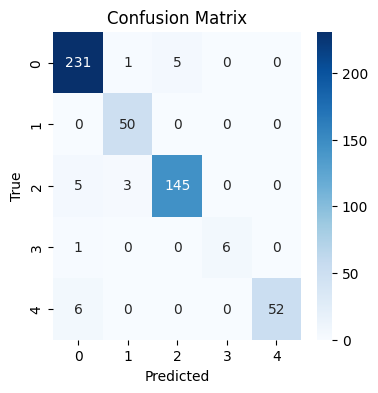

In [ ]:
# Generate the confusion matrix
cm = confusion_matrix(true_labels, predicted_classes)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(4, 4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=label_mapping.values(), yticklabels=label_mapping.values())
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
# Save the trained model
model.save_pretrained("/content/finbert_financial_classifier")

In [ ]:
# Save the tokenizer (this saves the vocabulary and special tokens)
tokenizer.save_pretrained("/content/finbert_tokenizer")

('/content/finbert_tokenizer/tokenizer_config.json',
 '/content/finbert_tokenizer/special_tokens_map.json',
 '/content/finbert_tokenizer/vocab.txt',
 '/content/finbert_tokenizer/added_tokens.json',
 '/content/finbert_tokenizer/tokenizer.json')

In [ ]:
# Accessing Training History Parameters
history.params

{'verbose': 1, 'epochs': 3, 'steps': 253}

In [ ]:
# Accessing Keys of Training History
history.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [ ]:
# Extracting Accuracy Metrics from Training History
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']

# Extracting Loss Metrics from Training History
loss = history.history['loss']
val_loss = history.history['val_loss']

In [ ]:
len(acc), len(val_acc), len(loss), len(val_loss)

(3, 3, 3, 3)

Text(0.5, 1.0, 'Training vs Validation Loss')

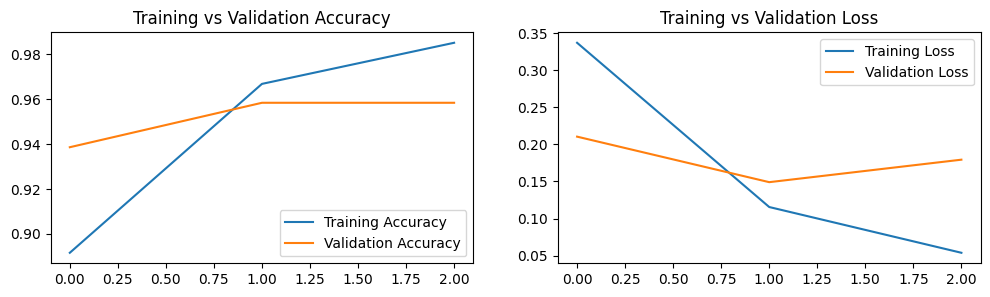

In [ ]:
# Visualize the Acuuracy & Loss using Plots

plt.figure(figsize=(12, 3))

plt.subplot(1, 2, 1)
plt.plot(range(len(acc)), acc, label='Training Accuracy')
plt.plot(range(len(val_acc)), val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training vs Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(len(loss)), loss, label='Training Loss')
plt.plot(range(len(val_loss)), val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training vs Validation Loss')

### **Model Deployment**

In [ ]:
# Login Hugging Face with Access Token
login()

In [ ]:
# Model Deploy to Hugging Face
model.push_to_hub('gopiashokan/Financial-Document-Classification-using-Deep-Learning')
tokenizer.push_to_hub('gopiashokan/Financial-Document-Classification-using-Deep-Learning')

### **Model Inference**

In [ ]:
def text_extract_from_html(html_file):

    # Open and Read the HTML File
    with open(file=html_file, mode='r', encoding='utf-8') as file:
        html_content = file.read()

    # Parse the HTML Content
    soup = BeautifulSoup(html_content, 'html.parser')

    # Extract the Text
    text = soup.get_text()

    # Split the Text and Remove Unwanted Space
    result = [i.strip() for i in text.split()]
    result = ' '.join(result)

    return result

In [ ]:
def classify_text_with_huggingface_api(extracted_text):

    # Load environment variables from .env file
    load_dotenv()

    # Retrieve the Hugging Face API token from environment variables
    hf_token = os.getenv("HUGGINGFACE_TOKEN")

    # Define the Hugging Face API URL for the model
    API_URL = "https://api-inference.huggingface.co/models/gopiashokan/Financial-Document-Classification-using-Deep-Learning"

    # Set the authorization headers with the Hugging Face token
    HEADERS = {"Authorization": f"Bearer {hf_token}"}

    # Send a POST request to the Hugging Face API with the extracted text
    response = requests.post(API_URL, headers=HEADERS, json={"inputs": extracted_text})

    # Parse and return the JSON response
    if response.status_code == 200:
        result = response.json()
        return result[0]

    else:
        return None

In [ ]:
def prediction(input_file):

    # Extract text from the uploaded HTML file
    extracted_text = text_extract_from_html(input_file)

    # Limit the extracted text to the first 512 characters to avoid API input limits
    extracted_text = extracted_text[0:512]

    # Classify the extracted text using the Hugging Face API
    result = classify_text_with_huggingface_api(extracted_text)

    if result is not None:
        # Select the prediction with the highest confidence score
        prediction = max(result, key=lambda x: x['score'])

        # Map model labels to human-readable class names
        label_mapping = {'LABEL_0':'Others', 'LABEL_1':'Balance Sheets', 'LABEL_2':'Notes', 'LABEL_3':'Cash Flow', 'LABEL_4':'Income Statement'}

        # Get the predicted class name based on the model output
        predicted_class = label_mapping[prediction['label']]

        # Convert the confidence score to a percentage
        confidence = prediction['score'] * 100

    else:
        print('Try Again Later')

    # Print the prediction results
    print(f'Predicted Class : {predicted_class}')
    print(f'Confidence : {confidence:.2f}%')

In [ ]:
prediction('/content/balance_Sheets_sample.html')

Predicted Class : Balance Sheets
Confidence : 99.55%


In [ ]:
prediction('/content/cash_flow_sample.html')

Predicted Class : Cash Flow
Confidence : 90.26%


In [ ]:
prediction('/content/income_statement_sample.html')

Predicted Class : Income Statement
Confidence : 99.63%


In [ ]:
prediction('/content/notes_sample.html')

Predicted Class : Notes
Confidence : 99.28%


In [ ]:
prediction('/content/others_sample.html')

Predicted Class : Others
Confidence : 99.90%
